# Preprocess, train, and upload an small intestine reference atlas

Created by Maren Büttner on 22.08.2020.

In this notebook, we are going to build a reference intestine atlas and share the model weights

In [1]:
import scarches as sca
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')

Using TensorFlow backend.


### load raw adata 

In [2]:
adata = sc.read("./data/adata_annotated_counts.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 70459 × 16878
    obs: 'batch', 'doublet_score', 'log_counts', 'louvain', 'mt_frac', 'n_counts', 'n_genes', 'ribo_frac', 'sample', 'cell_type', 'cell_type_refined'
    var: 'gene_ids', 'is_ambient-CD1', 'is_ambient-CD2', 'is_ambient-CD3', 'is_ambient-Anika_Control_1', 'is_ambient-Anika_Control_2', 'is_ambient-Anika_Control_3_FVR', 'is_ambient-Anika_Control_4_FVR', 'is_ambient-Anika_FVR', 'is_ambient-Anika_Mutant_1', 'is_ambient-Anika_Mutant_2_new', 'is_ambient-Anika_Mutant_3_FVR', 'is_ambient-Anika_Mutant_4_FVR', 'is_ambient-Anika_FVR_enriched', 'is_ambient-Anika_wholecrypt', 'n_cells'

`condition_key` is the column name which stores batch id in your `adata.obs`

In [4]:
condition_key = "batch"

We normalize the data and select 1000 highly variable genes using ` sca.data.normalize_hvg` this function return normalized data in
`adata.X` and raw count values in `adata.raw.X`. It also store noramlization factors in `adata.obs["size_factors"]`

In [5]:
adata = sca.data.normalize_hvg(adata,batch_key=condition_key,n_top_genes=1000)

Using 290 HVGs from full intersect set
Using 153 HVGs from n_batch-1 set
Using 145 HVGs from n_batch-2 set
Using 81 HVGs from n_batch-3 set
Using 60 HVGs from n_batch-4 set
Using 71 HVGs from n_batch-5 set
Using 57 HVGs from n_batch-6 set
Using 64 HVGs from n_batch-7 set
Using 77 HVGs from n_batch-8 set
Using 2 HVGs from n_batch-9 set
Using 1000 HVGs


In [6]:
adata

AnnData object with n_obs × n_vars = 70459 × 1000
    obs: 'batch', 'doublet_score', 'log_counts', 'louvain', 'mt_frac', 'n_counts', 'n_genes', 'ribo_frac', 'sample', 'cell_type', 'cell_type_refined', 'size_factors'
    var: 'gene_ids', 'is_ambient-CD1', 'is_ambient-CD2', 'is_ambient-CD3', 'is_ambient-Anika_Control_1', 'is_ambient-Anika_Control_2', 'is_ambient-Anika_Control_3_FVR', 'is_ambient-Anika_Control_4_FVR', 'is_ambient-Anika_FVR', 'is_ambient-Anika_Mutant_1', 'is_ambient-Anika_Mutant_2_new', 'is_ambient-Anika_Mutant_3_FVR', 'is_ambient-Anika_Mutant_4_FVR', 'is_ambient-Anika_FVR_enriched', 'is_ambient-Anika_wholecrypt', 'n_cells', 'mean', 'std'
    uns: 'log1p'

### create scArches network from scratch 

There are some parameters that worth to be mentioned here:

1. __task_name__: name of the task (i.e dataset) which you are going to train scArches on it.
2. __x_dimension__: number of dimensions in expression space
3. __z_dimension__: number of dimensions in latent space of scArches
4. __n_conditions__: list of unique conditions in your data (batches, datasets, or domains) (see above to get and idea)
5. __gene_names__: list of gene names used as scArches' input
6. __model_path__: path to save trained scArches model and its configuration files.
7. __alpha__: KL divergence coefficient for VAE. Biger alpha (1<=alpha<=0.1)  -> better mixing , small alpha (alpha <= 0.001): good mixing while having disctinct cell types
9. __loss_fn__: loss function to be used in scArches. Can be one of `mse`, `sse`, `nb`, or `zinb`. Please __NOTE__ that If you are going to use `nb` or `zinb` loss function, we suggest that setting `beta` hyperparameter to zero will be the best config for scArches to train on your task. 

__Note__ : `nb` (negative binomial) and `zinb` (zero inflated `nb`) require raw count data in your `adata.raw.X` and normalaized log-transformed values in `adata.X`. The data must also contain `adata.obs["size_factors"]`which are the normalization factor used
to normalze each cell count values. We suggest to use `scarches.data.normalize_hvg()` ([see here](https://scarches.readthedocs.io/en/latest/api/data.html)) function or use scanpy's `scanpy.pp.normalize_total(adata,...,key_added="size_factors")`([see here](https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.normalize_total.html#scanpy.pp.normalize_total)).

__HINT__ : we recommend to use `nb` loss, however if you did not find the results satisfying then consider using `sse`

In [7]:
network = sca.models.scArches(task_name='intestine_atlas',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 128],
                              gene_names=adata.var_names.tolist(),
                              conditions=adata.obs[condition_key].unique().tolist(),
                              alpha=0.001,
                              loss_fn='nb',
                              model_path="./models/scArches/",
                              )









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

scArchesNB's network has been successfully constructed!




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scArchesNB's network has been successfully compiled!


### train 

You can train scArches with `train` function with the following parameters:

1. __adata__: Annotated dataset used for training and evaluating scArches.
2. __condition_key__: name of the column in `obs` matrix in `adata` which contains the conditions for each sample.
3. __n_epochs__: number of epochs used to train scArches.
4. __batch_size__: number of sample used to sample as mini-batches in order to optmize scArches. 
8. __save__: whether to save scArches' model and configs after training phase or not. 
9. __retrain__: if `False` and scArches' pretrained model exists in `model_path`, will restore scArches' weights. Otherwise will train and validate scArches on `adata`. 

In [8]:
network.train(adata,
              condition_key=condition_key,
              n_epochs=30,
              batch_size=128, 
              save=True, 
              retrain=True)





 |████████████████████| 100.0%  - loss: 2.7433 - kl_loss: 13.9198 - recon_loss: 2.7294 - val_loss: 0.7818 - val_kl_loss: 3.8901 - val_recon_loss: 0.7779

scArchesNB has been successfully saved in ./models/scArches/intestine_atlas.


### UMAP visualization of latent space

Latent space representation of reference data can be obtained using `get_latent` function
This function has the following parameters:

1. __adata__: Annotated dataset to be transformed to latent space
2. __condition_key__: Name of the column in `obs` matrix in `adata` which contains the study for each sample.


In [9]:
latent_adata = network.get_latent(adata, condition_key)

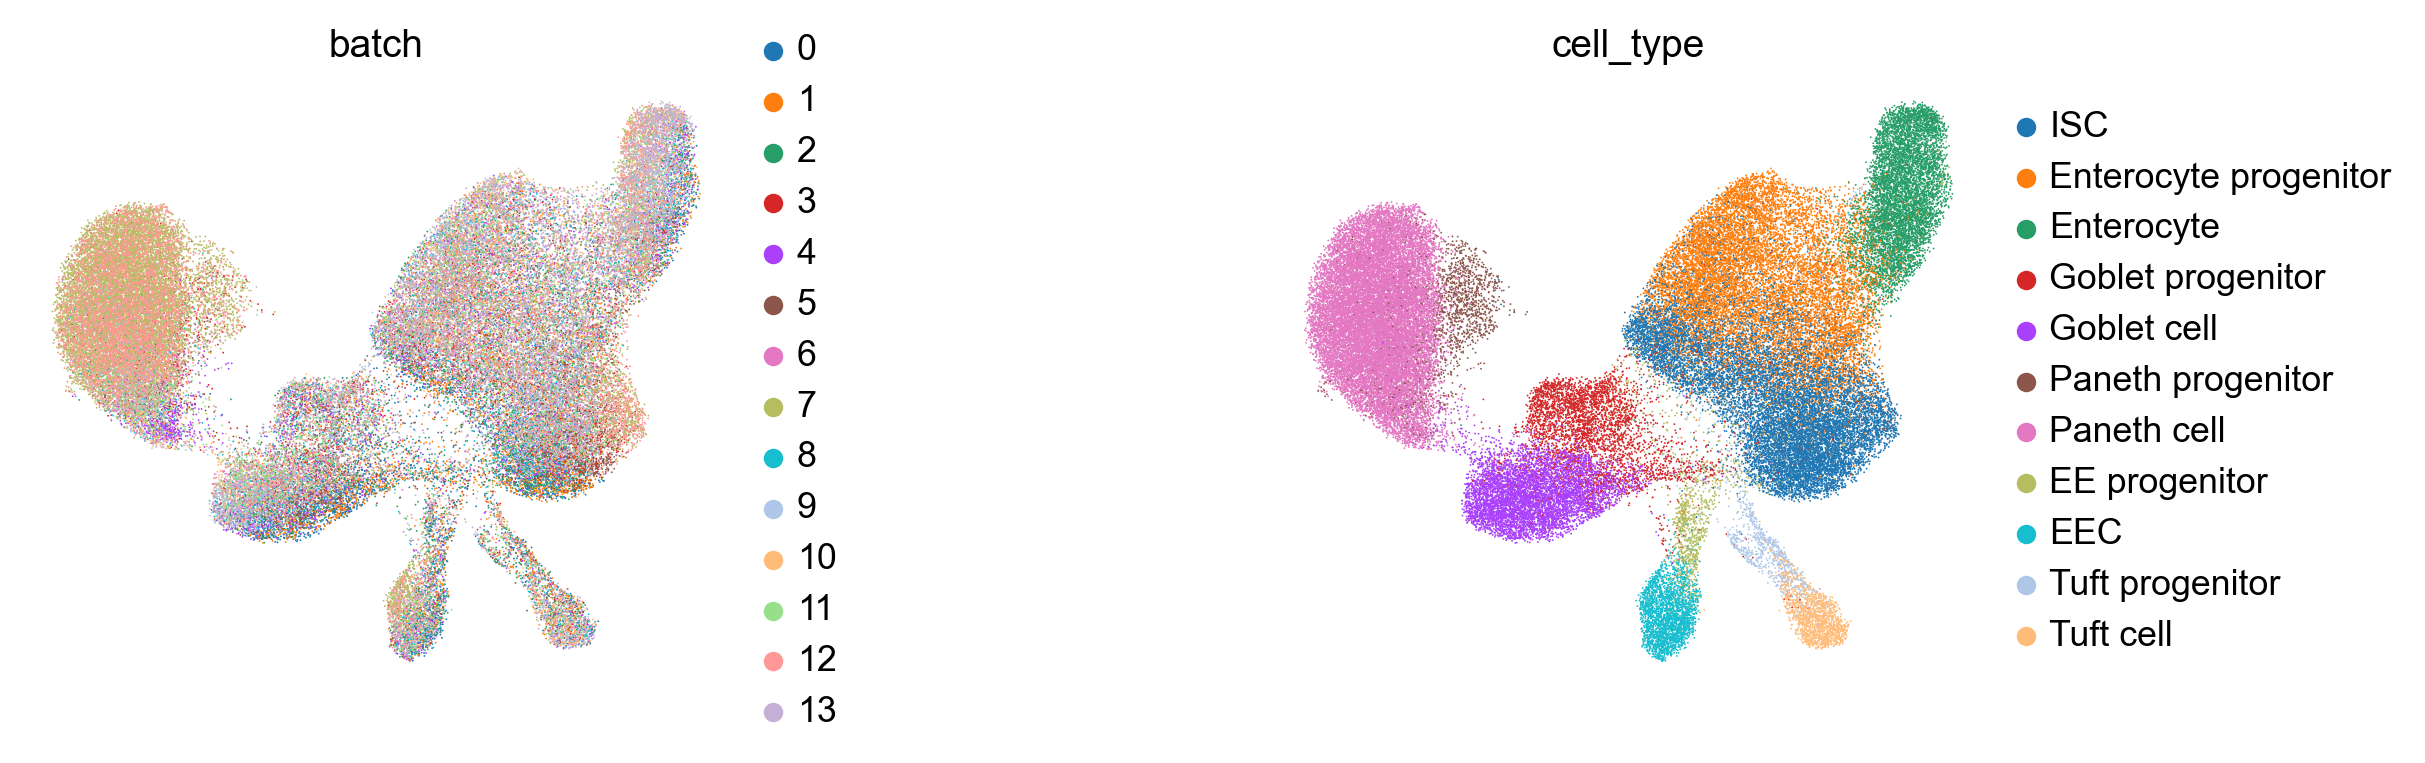

In [10]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=[condition_key, "cell_type"], 
           frameon=False, wspace=0.6)

### share your trained scArches with other researchers

You can easily get TOKEN by signing up in [**Zenodo**](https://zenodo.org/) Website and creating an app in the settings. You just have to following these steps for creating a new TOKEN: 

1. Sign in/Register in [__Zenodo__](https://zenodo.org/)
2. Go to __Applications__ page.
3. Click on __new_token__ in __Personal access tokens__ panel.
4. Give it access for `deposit:actions` and `deposit:write`.

__NOTE__: Zenodo will show the created TOKEN only once so be careful in preserving it. If you lost your TOKEN you have to create new one.

In [11]:
ACCESS_TOKEN = ""

### 1. create a deposition in your zenodo account

You can use wrapper functions in `zenodo` module in scArches package to interact with your depositions and uploaded files in Zenodo. In Zenodo, A deposition is a cloud space for a publication, poster, etc which contains multiple files.

In order to create a deposition in Zenodo, You can call our `create_deposition` function with the following parameters:

-  __access_token__: Your access token
-  __upload_type__: Type of the deposition, has to be one of the following types defined in [here](https://developers.zenodo.org/#representation).
-  __title__: Title of the deposition.
-  __description__: Description of the deposition.
-  __creators__: List of creators of this deposition. Each item in the list has to be in the following form:

```
{
    "name": "LASTNAME, FIRSTNAME", (Has to be in this format)
    "affiliation": "AFFILIATION", (Optional)
    "orcid": "ORCID" (Optional, has to be a valid ORCID)
}
```





In [12]:
deposition_id = sca.zenodo.create_deposition(ACCESS_TOKEN, 
                                             upload_type="other", 
                                             title='scArches-intestine',
                                             description='pre-trained scArches on intestine',                                            
                                             creators=[
                                                 {"name": "Büttner, Maren", "affiliation": "helmholtz center"},
                                             ],
                                             )

New Deposition has been successfully created!


### 2. upload your model to your deposition

After creating a deposition, you can easily upload your pre-trained scArches model using `upload_model` function in `zenodo` module. This function accepts the following parameters:

- __model__: Instance of scArches' class which is trained on your task
- __deposition_id__: ID of the deposition you want to upload the model in.
- __access_token__: Your TOKEN.

The function will return the generated `download_link` in order to use and provide other 

In [13]:
download_link = sca.zenodo.upload_model(network, 
                                        deposition_id=deposition_id, 
                                        access_token=ACCESS_TOKEN)

Model has been successfully uploaded


### 3. publish the created deposition

In [14]:
sca.zenodo.publish_deposition(deposition_id, ACCESS_TOKEN)

Deposition with id = 3995049 has been successfully published!


In [15]:
download_link

'https://zenodo.org/record/3995049/files/scNet-intestine_atlas.zip?download=1'

### 4. Enter model link in our database 

please fill this [form](https://docs.google.com/forms/d/1_j65-sRbHAGZsfDAXGVWLw4yEDe1czdtTCypfS6SPkw/viewform?ts=5f02c493&edit_requested=true) to enter the model in our database